In [2]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import torch
from torch import nn
from torch.utils.data import random_split, DataLoader
from torchvision.transforms import ToTensor
from tqdm import tqdm
import os

from droid_small import DroidDataset

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
def displayImageRow(ims, axis="off", figsize=None, titles=None, cmap=None, fontsize=None):
    if not titles:
        titles = [""] * len(ims)
    fig, axes = plt.subplots(1, len(ims), figsize=figsize)
    for i in range(len(ims)):
        axes[i].set_title(titles[i], fontsize=fontsize)
        axes[i].imshow(ims[i], cmap=cmap)
        axes[i].axis(axis)
    plt.show()

def save_frames_as_gif(frames: torch.Tensor, path: str, fps: int = 15):
    # Convert to (T, H, W, C) and to numpy
    if frames.dim() == 4 and frames.shape[1] in [1, 3]:
        frames = frames.permute(0, 2, 3, 1)  # (T, H, W, C)
    frames_np = frames.cpu().numpy()

    # Convert to [0, 255] uint8
    frames_np = (frames_np * 255).clip(0, 255).astype(np.uint8)

    # Save GIF
    os.makedirs(os.path.dirname(path), exist_ok=True)
    imageio.mimsave(path, frames_np, fps=fps)

def normalize(arr):
    return (arr - torch.min(arr)) / (torch.max(arr) - torch.min(arr))

In [4]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.gelu(self.bn(self.conv(x)))


class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.gelu(self.bn(self.conv(x)))


class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.convTranspose = nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.gelu(self.bn(self.convTranspose(x)))


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        self.avgPool = nn.AvgPool2d(7)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.gelu(self.avgPool(x))


class Unflatten(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, in_channels, 7, stride=7, padding=0)
        self.bn = nn.BatchNorm2d(in_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.gelu(self.bn(self.conv(x)))


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = Conv(in_channels, out_channels)
        self.conv2 = Conv(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv2(self.conv1(x))


class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = DownConv(in_channels, out_channels)
        self.conv2 = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv2(self.conv1(x))


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = UpConv(in_channels, out_channels)
        self.conv2 = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv2(self.conv1(x))


class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.fc1 = nn.Linear(in_channels, out_channels)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.fc2(self.gelu(self.fc1(x)))


class Concat(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x1: torch.Tensor, x2: torch.Tensor):
        assert(x1.shape[1:] == x2.shape[1:]), "Concat error: tensor shape mismatch"
        return torch.cat((x1, x2), dim=1)


In [5]:
import torch
import torch.nn as nn

class WorldModelUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        action_dim: int,
        k: int,
        num_hiddens: int,
    ):
        super().__init__()
        D = num_hiddens
        self.D = D

        self.convB1 = ConvBlock(in_channels + k * 3, D)
        self.convB2 = ConvBlock(2 * D, D)

        self.downB1 = DownBlock(D, D)
        self.downB2 = DownBlock(D, 2 * D)
        self.upB1 = UpBlock(4 * D, D)
        self.upB2 = UpBlock(2 * D, D)

        self.fc1_t = FCBlock(1, 2 * D)
        self.fc2_t = FCBlock(1, D)

        self.fc1_a = FCBlock(k * action_dim, 2 * D)
        self.fc2_a = FCBlock(k * action_dim, D)

        self.final_conv = nn.Conv2d(D, 3, 3, stride=1, padding=1)

        self.concatB = Concat()

    def forward(
        self,
        x: torch.Tensor,             # (N, 3, H, W) noised frame
        frames_cond: torch.Tensor,   # (N, k, 3, H, W) past frames
        actions_cond: torch.Tensor,  # (N, k, action_dim) past actions
        t: torch.Tensor,             # (N, 1) diffusion timestep
    ) -> torch.Tensor:
        N, k, C, H, W = frames_cond.shape
        frames_flat = frames_cond.view(N, k * C, H, W)   # (N, k*3, H, W)
        actions_flat = actions_cond.view(N, -1)          # (N, k*action_dim)

        # Time and action embeddings
        cond_t1 = self.fc1_t(t).unsqueeze(-1).unsqueeze(-1)  # (N, 2D, 1, 1)
        cond_t2 = self.fc2_t(t).unsqueeze(-1).unsqueeze(-1)  # (N, D, 1, 1)

        cond_a1 = self.fc1_a(actions_flat).unsqueeze(-1).unsqueeze(-1)  # (N, 2D, 1, 1)
        cond_a2 = self.fc2_a(actions_flat).unsqueeze(-1).unsqueeze(-1)  # (N, D, 1, 1)

        # U-Net
        x_in = torch.cat([x, frames_flat], dim=1)  # (N, (1+k)*3, H, W)

        t1 = self.convB1(x_in)         # (N, D, H, W)
        t2 = self.downB1(t1)            # (N, D, H/2, W/2)
        t3 = self.downB2(t2)            # (N, 2D, H/4, W/4)

        # Apply FiLM conditioning
        t4 = t3 * cond_a1 + cond_t1     # (N, 2D, H/4, W/4)

        t5 = self.concatB(t4, t3)       # (N, 4D, H/4, W/4)

        t6 = self.upB1(t5)              # (N, D, H/2, W/2)
        t6 = t6 * cond_a2 + cond_t2

        t7 = self.concatB(t6, t2)       # (N, 2D, H/2, W/2)

        t8 = self.upB2(t7)              # (N, D, H, W)

        t9 = self.concatB(t8, t1)       # (N, 2D, H, W)

        t10 = self.convB2(t9)           # (N, D, H, W)

        return self.final_conv(t10)     # (N, 3, H, W)

In [6]:
def fm_forward(
    unet: WorldModelUNet,
    x_1: torch.Tensor,
    frames_cond: torch.Tensor,
    actions_cond: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:
    """
    Args:
        unet: WorldModelUNet
        x_1: (N, 3, H, W) input tensor (next frame diff).
        frames_cond: (N, k, 3, H, W) past K frames.
        actions_cond: (N, k, action_dim) past K actions.
        p_uncond: probability of unconditioning the conditioning inputs.
        num_ts: number of diffusion timesteps.

    Returns:
        scalar loss
    """
    unet.train()

    N = x_1.shape[0]

    # Randomly uncondition: (N, 1)
    mask = torch.bernoulli(torch.full((N, 1), 1 - p_uncond, device=device))  # (N, 1)

    # Apply mask
    frames_cond = frames_cond * mask.view(N, 1, 1, 1, 1)  # (N, k, 3, H, W)
    actions_cond = actions_cond * mask.view(N, 1, 1)      # (N, k, action_dim)

    # Diffusion time
    t = torch.rand((x_1.shape[0], 1, 1, 1), device=device)  # (N, 1, 1, 1)

    # Corrupt input
    x_0 = torch.randn_like(x_1)
    x_t = (1 - t) * x_0 + t * x_1

    # Predict
    u_pred = unet(x_t, frames_cond, actions_cond, t.view(N, -1))        # all original shapes

    # Target velocity
    u = x_1 - x_0

    return nn.functional.mse_loss(u_pred, u), u_pred

In [7]:
@torch.inference_mode()
def fm_sample(
    unet: WorldModelUNet,
    frames_cond: torch.Tensor,   # (N, k, 3, H, W)
    actions_cond: torch.Tensor,  # (N, k, action_dim)
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0,
    N: int = 10,
    seed: int = 0,
) -> torch.Tensor:
    """Sampling with past K frame and action conditioning."""
    unet.eval()

    torch.manual_seed(seed)
    H, W = img_wh
    step_size = 1 / num_ts

    # Prepare unconditional conditioning (zeros)
    frames_cond_zero = torch.zeros_like(frames_cond)      # (N, k, 3, H, W)
    actions_cond_zero = torch.zeros_like(actions_cond)    # (N, k, action_dim)

    # Initialize x_t (noise)
    x_t = torch.randn((N, 3, H, W), device=device)         # predict next frame difference (3 channels)

    for i in range(num_ts + 1):
        t = torch.full((N, 1), i / num_ts, device=device)  # (N, 1)

        # Predict u_cond
        u_cond_pred = unet(x_t, frames_cond, actions_cond, t)

        # Predict u_uncond (zeroed frames/actions)
        u_uncond_pred = unet(x_t, frames_cond_zero, actions_cond_zero, t)

        # Classifier-free guidance
        u_pred = u_uncond_pred + guidance_scale * (u_cond_pred - u_uncond_pred)

        # Update x_t
        x_t += step_size * u_pred

    return x_t

In [9]:
class FlowMatching(nn.Module):
    def __init__(
        self,
        unet: WorldModelUNet,
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.num_ts = num_ts
        self.p_uncond = p_uncond

    def forward(
        self,
        x: torch.Tensor,
        frames_cond: torch.Tensor,
        actions_cond: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, 3, H, W) target next frame difference.
            frames_cond: (N, k, 3, H, W) past frames.
            actions_cond: (N, k, action_dim) past actions.

        Returns:
            scalar loss.
        """
        return fm_forward(
            self.unet, x, frames_cond, actions_cond, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        frames_cond: torch.Tensor,
        actions_cond: torch.Tensor,
        img_wh: tuple[int, int],
        guidance_scale: float = 5.0,
        N: int = 10,
        seed: int = 0,
    ) -> torch.Tensor:
        """
        Args:
            frames_cond: (N, k, 3, H, W) past frames.
            actions_cond: (N, k, action_dim) past actions.
            img_wh: (H, W) image size.
            guidance_scale: float, classifier-free guidance scale.
            N: batch size.
            seed: int, random seed.

        Returns:
            (N, 3, H, W) predicted frame difference samples.
        """
        return fm_sample(
            self.unet, frames_cond, actions_cond, img_wh, self.num_ts, guidance_scale, N, seed
        )

## Train 3: Predict Difference with Cascaded Models

In [10]:
device = "cuda"

# Hyperparameters
D = 128
learning_rate = 1e-4
num_epochs = 10
test_epochs = [1, 2, 4, 7, 10]
batch_size = 64
K = 5
N = 5   # number of cascaded models
sample_rate = 0.5   # probability of sampling gt

# Load dataset and split
dataset = DroidDataset(k=K+N, frame_size=(64, 64), dir="drive/MyDrive/CS280/droid_small", video_source="observation.images.exterior_1_left")
print(len(dataset))
train_size = int(0.5 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = random_split(dataset, [train_size, test_size])

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# Define model
models = [
    FlowMatching(WorldModelUNet(
        in_channels=3,
        action_dim=8,
        k=K,
        num_hiddens=D,
    )).to(device)
    for _ in range(N)
]

# Optimizer and scheduler
optimizers = [
    torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    for model in models
]
schedulers = [
    torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=num_epochs)
    for opt in optimizers
]

training_losses = []
test_data = []

try:
    for epoch in range(num_epochs):
        for model in models:
            model.train()
        avg_train_loss = 0

        for frames_cond, actions_cond, _, _ in tqdm(trainloader):
            frames_cond = frames_cond.to(device)     # (B, k, 3, H, W)
            actions_cond = actions_cond.to(device)   # (B, k, action_dim)

            for opt in optimizers:
                opt.zero_grad()
            # loss = 0
            B = frames_cond.size(0)
            pred_frames = frames_cond[:, :K].clone()

            for i, model in enumerate(models):
                frames_cond_i = frames_cond[:, i:i+K]   # (B, k, 3, H, W)
                frames_cond_pred_i = pred_frames        # (B, k, 3, H, W)
                mask = (torch.rand(B, K, 1, 1, 1, device=device) < sample_rate).float()
                frames_cond_mix_i = mask * frames_cond_i + (1 - mask) * frames_cond_pred_i

                actions_cond_i = actions_cond[:, i:i+K]

                frame_cur_i = frames_cond_mix_i[:, -1]
                frame_next_i = frames_cond[:, i+K]
                label_i = frame_next_i - frame_cur_i

                loss_i, pred_i = model(label_i, frames_cond_mix_i, actions_cond_i)

                pred_next_frame = frame_cur_i + pred_i.detach()
                pred_frames = torch.cat([pred_frames[:, 1:], pred_next_frame.unsqueeze(1)], dim=1)

                loss_i.backward()
                optimizers[i].step()

            for scheduler in schedulers:
                scheduler.step()

            avg_train_loss += loss_i.item() / len(trainloader)
            training_losses.append(loss_i.item())

        # scheduler.step()
        print(f"Epoch {epoch + 1}, Avg Training Loss: {avg_train_loss:.6f}")

        # testing (sampling)
        if (epoch + 1) in test_epochs:
            for model in models:
                model.eval()
            batch = next(iter(testloader))
            frames_cond, actions_cond, _, ground_truth = batch

            frames_cond = frames_cond.to(device)
            actions_cond = actions_cond.to(device)

            # Only take the most recent frame (the latest in frames_cond sequence)
            current_frame = frames_cond[:, -1]  # (N, 3, H, W)

            # Sample the predicted difference
            predicted_diff = models[-1].sample(
                frames_cond[:10],
                actions_cond[:10],
                img_wh=(frames_cond.shape[-2], frames_cond.shape[-1]),
                guidance_scale=5.0,
                N=10,  # should match frames_cond[:10]
            ).cpu()

            # Compute predicted next frames
            predicted_next_frame = current_frame[:10].cpu() + predicted_diff  # add predicted delta

            # Display first few predicted next frames
            displayImageRow(predicted_next_frame.permute(0, 2, 3, 1), figsize=(10,10))
            displayImageRow(ground_truth[:10].permute(0, 2, 3, 1), figsize=(10,10))

            # test_data.append(predicted_next_frame.numpy())

finally:
    dataset.close()

68971


100%|██████████| 539/539 [1:03:01<00:00,  7.02s/it]


Epoch 1, Avg Training Loss: 0.470681


RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x80 and 40x256)

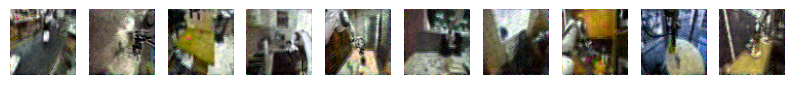

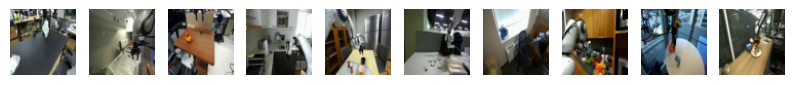

In [11]:
dataset = DroidDataset(k=K+N, frame_size=(64, 64), dir="drive/MyDrive/CS280/droid_small", video_source="observation.images.exterior_1_left")
train_size = int(0.5 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = random_split(dataset, [train_size, test_size])

try:

    for model in models:
        model.eval()
    batch = next(iter(testloader))
    frames_cond, actions_cond, _, ground_truth = batch

    frames_cond = frames_cond.to(device)
    actions_cond = actions_cond.to(device)

    # Only take the most recent frame (the latest in frames_cond sequence)
    current_frame = frames_cond[:, K]  # (N, 3, H, W)

    # Sample the predicted difference
    predicted_diff = models[-1].sample(
        frames_cond[:10, :K],
        actions_cond[:10, :K],
        img_wh=(frames_cond.shape[-2], frames_cond.shape[-1]),
        guidance_scale=5.0,
        N=10,  # should match frames_cond[:10]
    ).cpu()

    # Compute predicted next frames
    predicted_next_frame = current_frame[:10, :K].cpu() + predicted_diff  # add predicted delta

    # Display first few predicted next frames
    displayImageRow(predicted_next_frame.permute(0, 2, 3, 1), figsize=(10,10))
    displayImageRow(ground_truth[:10].permute(0, 2, 3, 1), figsize=(10,10))

finally:
    dataset.close()

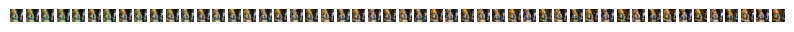

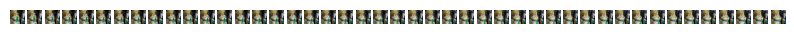

In [24]:
test_dataset = DroidDataset(k=50, frame_size=(64, 64), dir="drive/MyDrive/CS280/droid_small", video_source="observation.images.exterior_1_left")

try:
    frames, actions, _, _ = test_dataset[150]
    frames_cond = frames[:K]

    pred_frames = frames_cond.clone().to(device)
    actions = actions.to(device)

    for i in range(K, 50):
        pred_diff = models[-1].sample(
            pred_frames[-K:].unsqueeze(0),               # last K predicted frames
            actions[i-K:i].unsqueeze(0),                 # corresponding K actions
            img_wh=(frames.shape[-2], frames.shape[-1]),
            guidance_scale=5.0,
            N=1,
        )
        pred = pred_frames[-1] + pred_diff
        pred = pred.clamp(0, 1)
        pred_frames = torch.cat([pred_frames, pred], dim=0)  # append prediction

finally:
    test_dataset.close()

displayImageRow(pred_frames.cpu().permute(0, 2, 3, 1), figsize=(10,10))
displayImageRow(frames[K:].permute(0, 2, 3, 1), figsize=(10,10))
save_frames_as_gif(pred_frames, "output/predicted_1.gif")
save_frames_as_gif(frames, "output/ground_truth_1.gif")
